### Procedurally generated worlds using Pandas and Numpy
I'm a big fan of rouge-like games and RPGs. I'm also a big fan of data science tools for Python. This is my attempt to have it all. Because these notebooks call from modules used in the live game, I also use them for dev / testing. If something is crashing in the game I can simulate it here to see what is wrong and test out new features before dropping them in the production code. 

In the live game there are three stages of creation:
* The age of **elements** - building terrain
* The age of **mortals** - adding cities and nations
* The age of **conflict** - random events that shift the relationships between nations, towns and people.

Currently only 1 and 2 are shown here. 


In [1]:
import pandas as pd
import numpy as np
import pickle

import altair as alt

#importing local libraries for drawings (because they clutter)
#I'm mapping to the actual files in the repo so that I can also use this to troubleshoot
import sys, os, yaml
sys.path.append('../')
sys.path.append('../../')

import lib.drawMaps as draw


In [2]:
import django
os.environ.setdefault('DJANGO_SETTINGS_MODULE', 'prodweb.settings')
django.setup()
from lib.builders import world as w, landscape as l
from lib.builders import people,towns,nations, events,culture as c


There are default parameters that I've chosen as the best fit for creating a _ 'believable' _ world. You can experiment with those variables by editing them here. They won't affect the production parameters. 


In [3]:
l.default_params

{'grid': [40, 40], 'N_loc': 0, 'N_std': 1, 'water_level': 20}

In [4]:
landscape = l.Landscape()
landscape

I'm going to use the `landscape` over and over to specify the world's parameters. Some of the parameters are set by the user and some of them are hard cast. 

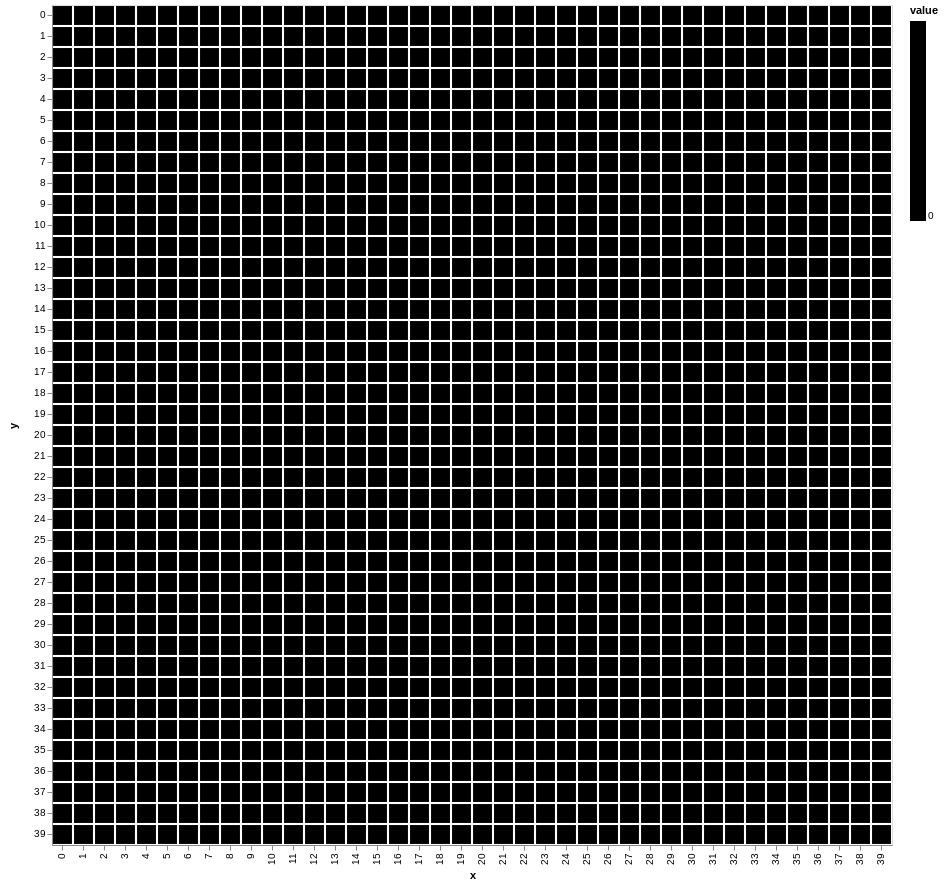

In [5]:
world = w.World(landscape)
draw.drawTerrainHeight(world.grid_elevation)

# in the beginning, the world was void and without form.

Starting with a grid with nothing on it. No elevation, no terrain. All of this will be generated procedurally. 

You can see here that the terrain is shifted on a random-normal distribution to make it look _uneven_. Making it randomly doesn't make it look _real_ so I'm going to have to be smarter about the rules that raise and lower terrain in order to make them look like mountains. 

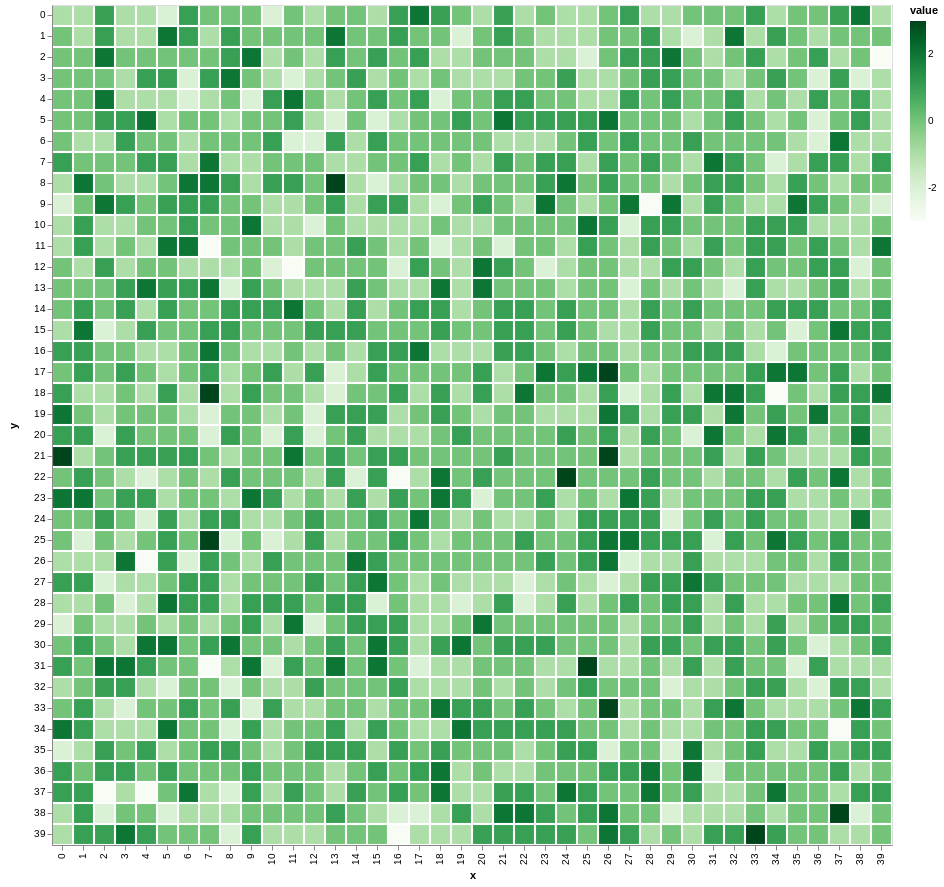

In [6]:
world.shift_terrain()
draw.drawTerrainHeight(world.grid_elevation)

Just random terrain shifting won't make anything like real terrain types. 

# Mountains formed

Using Np.pad to build a pyramid, I'm making something that looks much more like a mountain. This is just a single mountain. 

In [7]:
world.getMountain()

,0,1,2
0,1,1,1
1,1,2,1
2,1,1,1


This is great, but I need to place the mountain on a random place on the terrain. Currently just drop the edges of the mountain if they go off the grid. I might wrap them around later. **Note** height needs to be odd in order to draw symmetrically.

In [8]:
coord = world.get_random_chord()
m = world.getMountain(height=5)
print("Mountain Placed: ", coord)

mdf = world.reindexMountain(coord,m)
mdf

Mountain Placed:  [30 39]


,35,36,37,38,39,40,41,42,43
26,1,1,1,1,1,1,1,1,1
27,1,2,2,2,2,2,2,2,1
28,1,2,3,3,3,3,3,2,1
29,1,2,3,4,4,4,3,2,1
30,1,2,3,4,5,4,3,2,1
31,1,2,3,4,4,4,3,2,1
32,1,2,3,3,3,3,3,2,1
33,1,2,2,2,2,2,2,2,1
34,1,1,1,1,1,1,1,1,1


This makes a much more _natural_ looking mountain. 

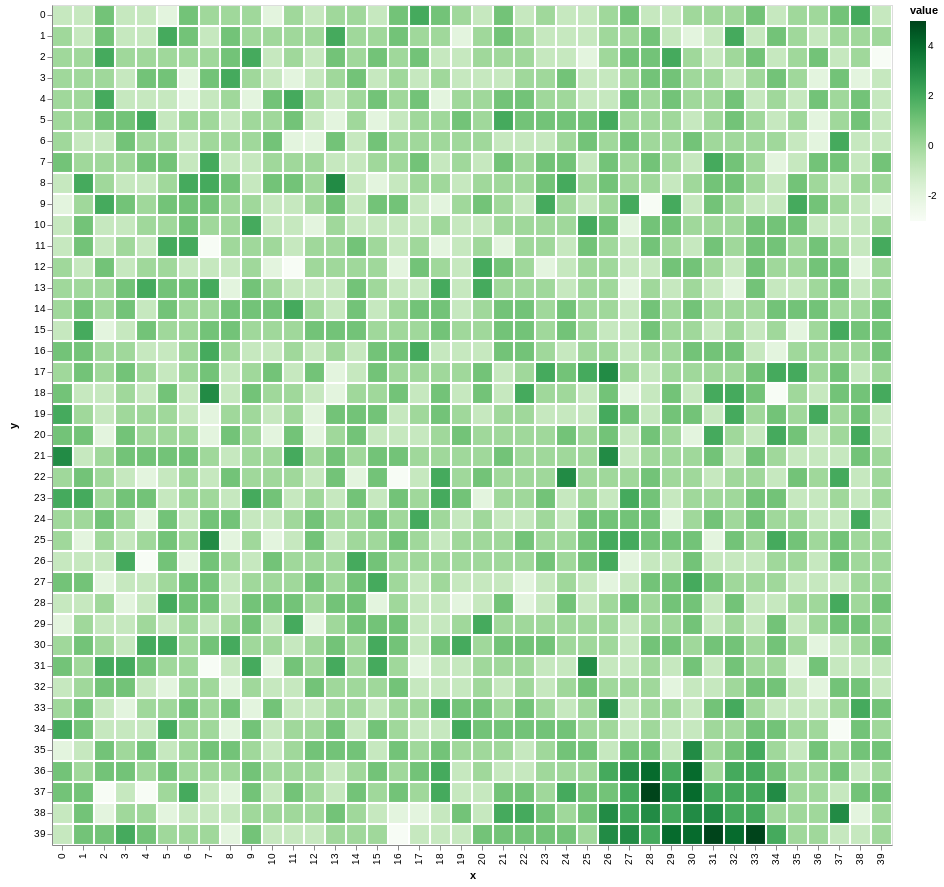

In [9]:
world.add_mountain(mdf)
draw.drawTerrainHeight(world.grid_elevation)

It's a good looking mountain, but I need mountain ranges not dots. In order to drag mountains on the board I'll need to create a brownian motion function to drop a mountain and then move. 

In [10]:
world.brownian_land()

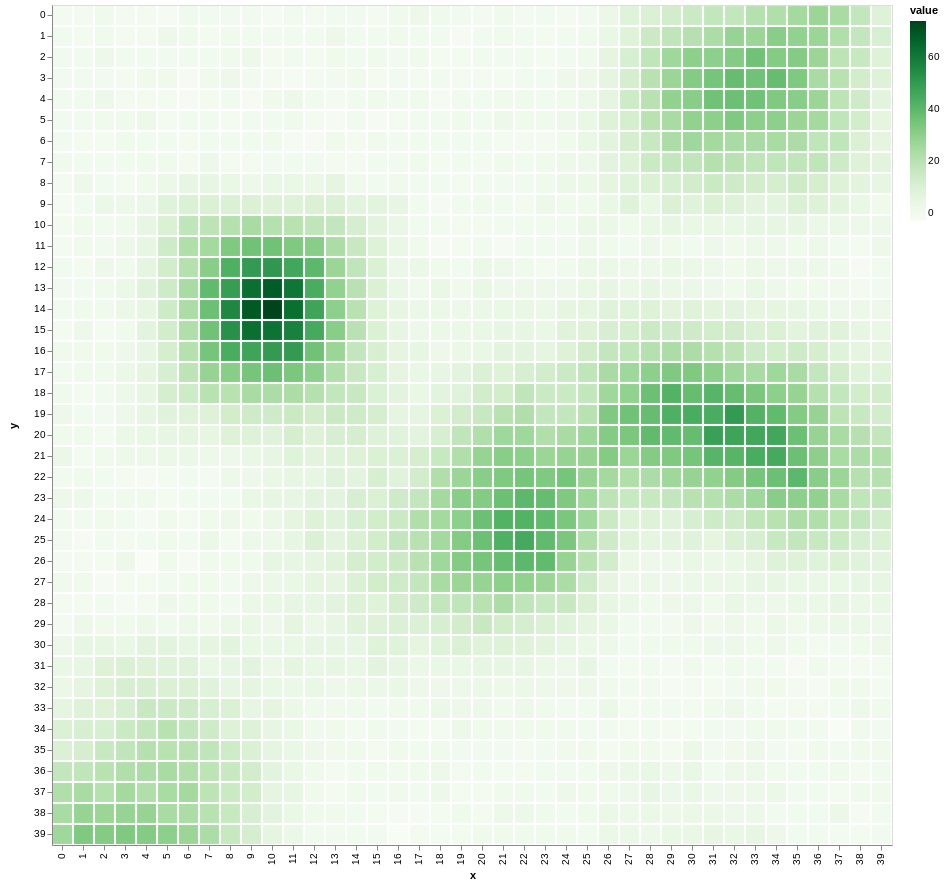

In [11]:
draw.drawTerrainHeight(world.grid_elevation)

Now that's starting to look like land. The shapes come out really map-like. Compute time is lower than my previous version as well. Only drawing the Altair viz takes time. 

## Oceans

If the oceans were to come in at `height == 0` then you can assume that lower terrain is _under water_

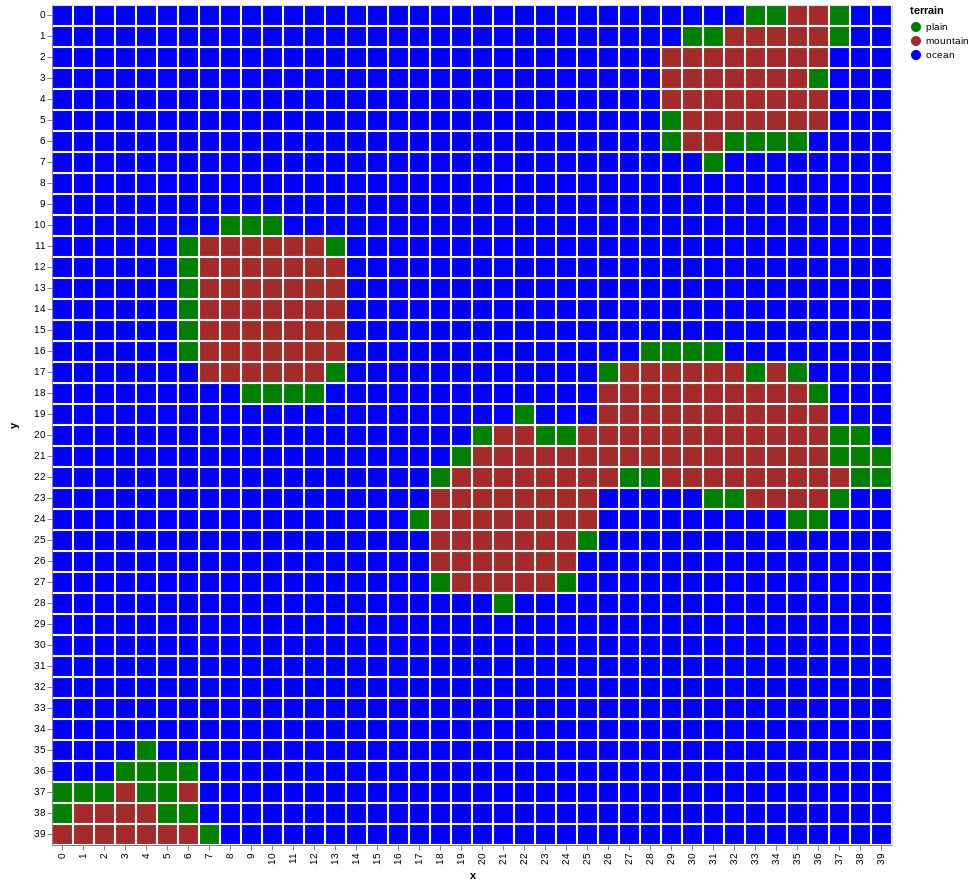

In [12]:
draw.drawTerrainTypes(world.grid_elevation,world.landscape)

### Rainfall

Rainfall makes terrain different. Wet areas become forests. Dry areas become deserts. 

In [13]:
world.brownian_rainfall()

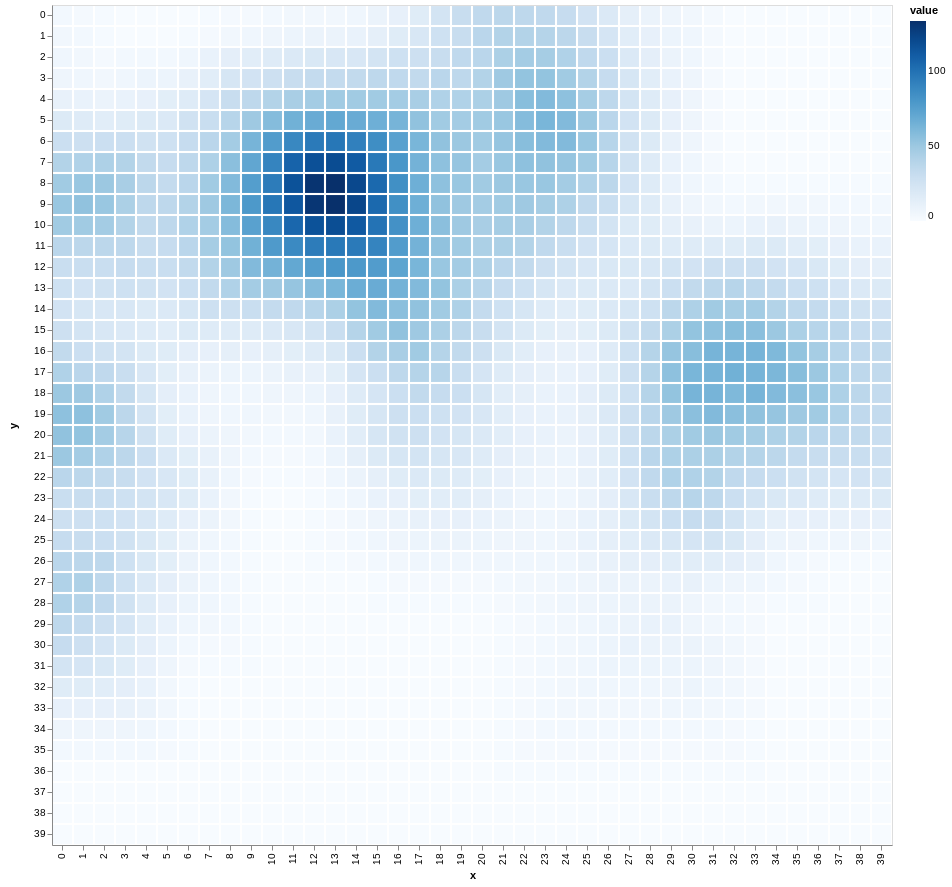

In [14]:
draw.drawRainFall(world.grid_rainfall)

### Build core game features dataframe
This function builds the df_features that will be used later in the actual game. This way you can quickly search and filter the world to find things.

In [15]:
world.build_df_features()

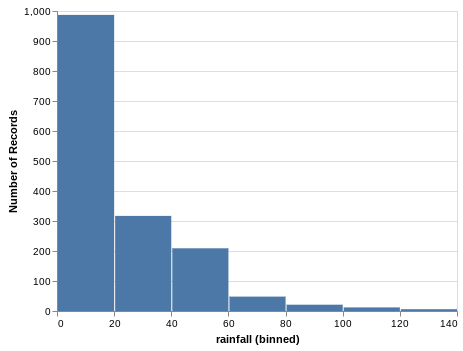

In [16]:
alt.Chart(world.df_features).mark_bar().encode(
    alt.X("rainfall", bin=True),
    y='count()',
)

The amount of rainfal in the world determines if the area will become a forest or a desert. This can be set from the `landscape` parameters. 

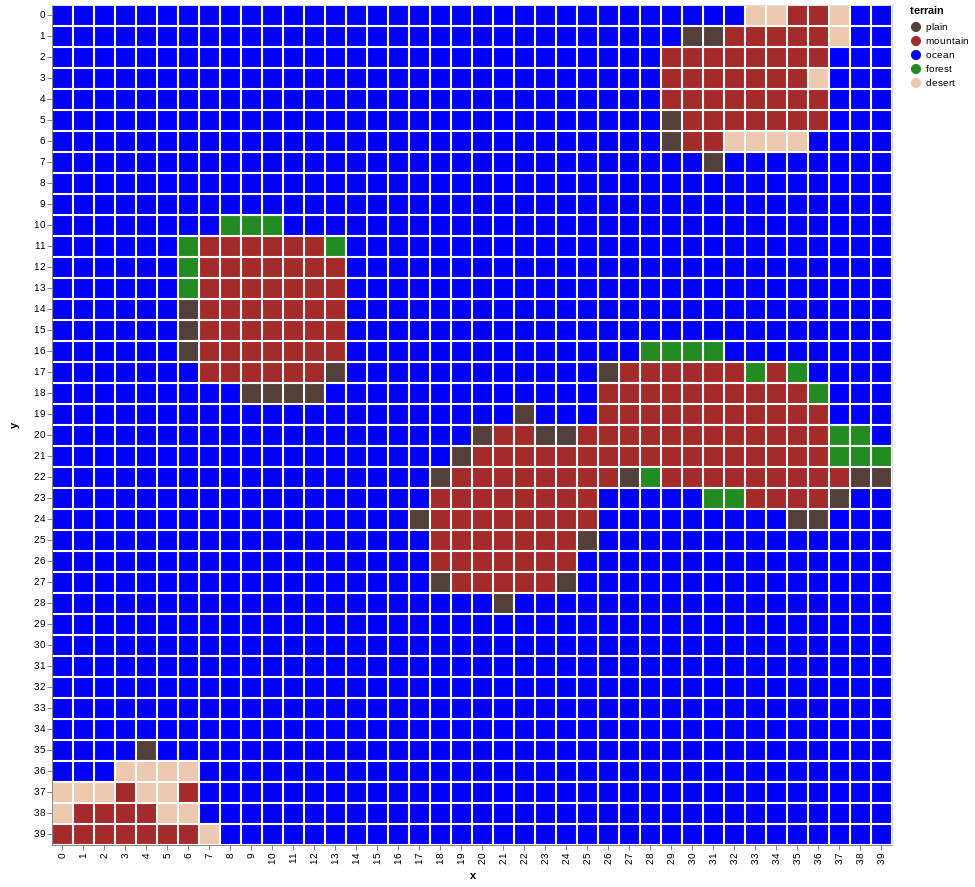

In [17]:
world.df_features['terrain'] = world.df_features.apply(lambda x: w.set_ecology(x,landscape),axis =1 )
draw.drawterrainadvanced(world.df_features)

# The age of the Mortals

The terrain and all of the natural features are formed in the first age. Mountains, rivers, lakes and forests. Once the land has settled, the first cities appear. 

Culture settings come from the user input, there are defaults for everything. Once specified the `.culture` placeholder can be replaced. It should not be used until this point. 


In [18]:
c

<module 'lib.builders.culture' from '../lib/builders/culture.py'>

In [19]:
# the path to the `datasets` folder is different when launched in the Notebook.
culture = c.Culture(paths='notebooks')
world.culture = culture
world.culture.eons

10

## People
A `Person` is a required parameter for many things like `towns`, `nations` and `buildings`

A person requires a `culture` to specify how the names will be generated. As a default the person is a `peon` and exists nowhere (`None`). Optional parameters allow the person to be created with a `role` and a `location`. `Location` can be a `town`, `building` or a `key` where the person can be found. 

In [20]:
people.Person(world.culture,location=world.get_random_chord())

Quaddend the commoner

## Towns

the `__init__` method of a city takes a founding age and a location (which can be generated randomly via `World.get_random_chord`). The init method automatically generates a name. The default nation is the name of the town.

In [21]:
new_town = towns.Town(world.get_random_chord(),1,culture,people)
new_town

town of Spincoil: population: 1 location: [11,39] founded 1

In [22]:
new_town.speaker

Piflart the Speaker of Spincoil

## The age of civilization

Cities grow for a set number of aeons. During each eon
* n new villages are born
* each village has g% chance to grow

The cities are randomly placed (not in the ocean)

In [23]:
all_towns = towns.build_towns(world,people)
world.towns = all_towns
[(str(p),p.population) for p in all_towns]

[('town of Foundersmark: population: 6 location: [35,18] founded 0',
  [Alinoddunt the Speaker of Foundersmark,
   Hihumber the commoner,
   Anafillal the commoner,
   Scaxea the commoner,
   Brahallenton the commoner,
   Thoblun the commoner]),
 ('town of Buckwish: population: 3 location: [22,25] founded 1',
  [Molindai the Speaker of Buckwish,
   Erirpir the commoner,
   Malindust the commoner]),
 ('town of Servantsborourgh: population: 5 location: [29,17] founded 1',
  [Anardumber the Speaker of Servantsborourgh,
   Taharkah the commoner,
   Orzennadle the commoner,
   Scomattif the commoner,
   Scotallunt the commoner]),
 ('town of Servantswish: population: 2 location: [31,1] founded 1',
  [Prawillenton the Speaker of Servantswish, Pammnan the commoner]),
 ('town of Stonebrook: population: 5 location: [32,1] founded 2',
  [Illiavalless the Speaker of Stonebrook,
   Brosalked the commoner,
   Bewef the commoner,
   Vappat the commoner,
   Trirrik the commoner]),
 ('town of Soilcraft

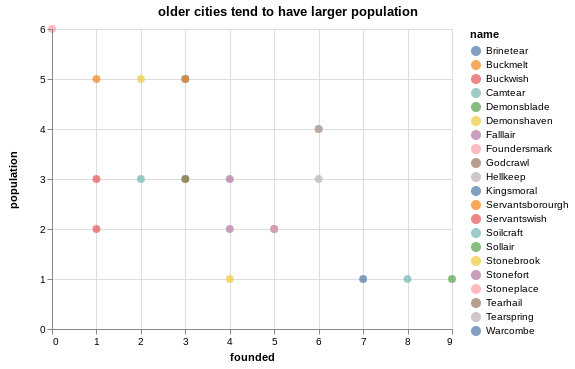

In [24]:
def population_age(towns):
    df = pd.DataFrame(index=range(len(all_towns)))
    df['name'] = [t.name for t in all_towns]
    df['population'] = [t.pop for t in all_towns]
    df['founded'] = [t.founded for t in all_towns]
    return df

alt.Chart(population_age(towns),title="older cities tend to have larger population").mark_circle(size=60).encode(
    y='population',
    x='founded',
    color='name',
    tooltip=['name']
)

## Adding the towns to the map: 
Redrawing the map adds the cities. Note that all cities have a specific age, population. People in those cities have names, occupations and varying levels of loyalty and temperment.

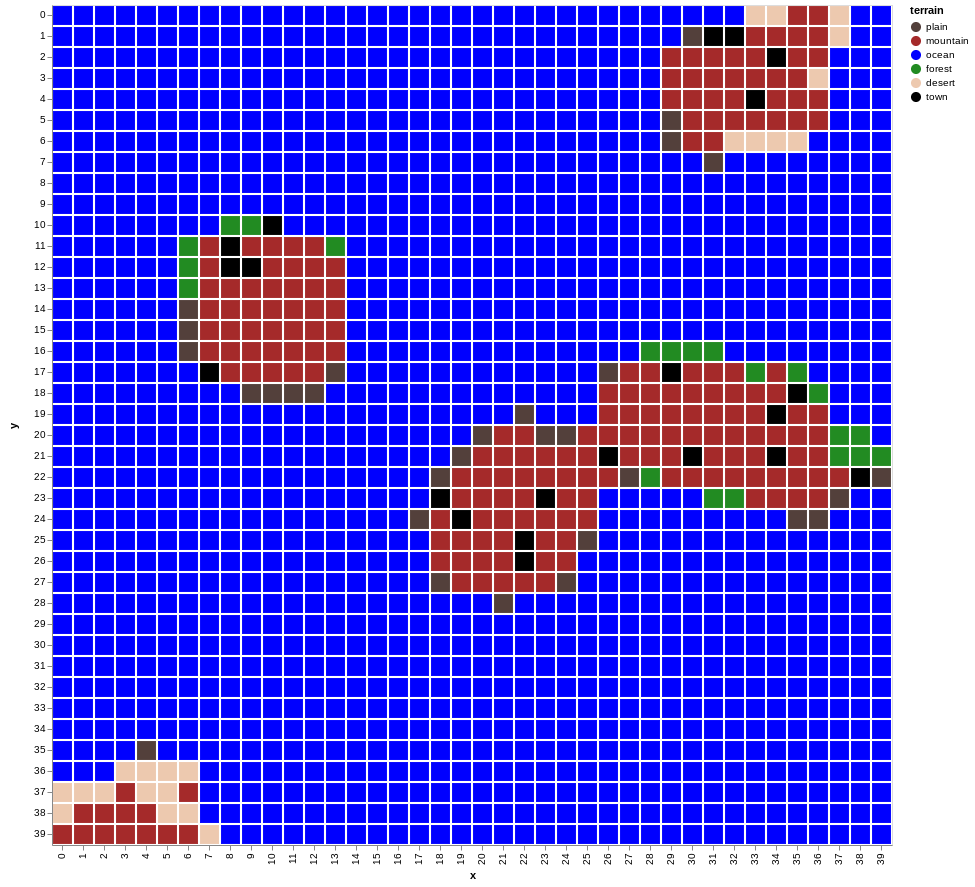

In [25]:
world.add_features(all_towns)
#TODO: Update drawCities to support more terrain types
draw.drawCities(world.df_features)

**Towns** are a __feature__ of the terrain. The terrain determines what `terr_items` and `terr_details` will be in that area, and the __feature__ determines special things for that space.

In [26]:
world.df_features[world.df_features['feature'].isna()==False]

,y,rainfall,x,key,elevation,terrain,feature
key,,,,,,,
31:1,1,2.0,31,31:1,23.0,town,Servantswish
32:1,1,0.0,32,32:1,28.0,town,Stonebrook
34:2,2,0.0,34,34:2,32.0,town,Hellkeep
33:4,4,0.0,33,33:4,36.0,town,Demonsblade
10:10,10,88.0,10,10:10,21.0,town,Buckmelt
8:11,11,53.0,8,8:11,33.0,town,Stonefort
8:12,12,49.0,8,8:12,43.0,town,Soilcraft
9:12,12,59.0,9,9:12,50.0,town,Camtear
7:17,17,8.0,7,7:17,28.0,town,Kingsmoral


# Nations

In [27]:
#k is the actual k_means cluster object.
all_nations,k = nations.cluster_nations(world)
world.nations = all_nations

all_nations

{0: 'Waterblade',
 1: 'Helllight',
 2: 'Gleamridge',
 3: 'Demonslight',
 4: 'Earthridge',
 5: 'Landsspring',
 6: 'Artspring',
 7: 'Camtear'}

Standard Scikit-Learn stuff. I'm using K-means to group the `towns` into `nations` based on proximity.

In [28]:
k

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [29]:
world.df_features = nations.predict_nations(k,world)
world.df_features.head(20)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
0:0,0,3.0,0,0:0,-1.0,ocean,NaN,NaN,NaN
1:0,0,2.0,1,1:0,-1.0,ocean,NaN,NaN,NaN
2:0,0,1.0,2,2:0,1.0,ocean,NaN,NaN,NaN
3:0,0,0.0,3,3:0,-1.0,ocean,NaN,NaN,NaN
4:0,0,0.0,4,4:0,-1.0,ocean,NaN,NaN,NaN
5:0,0,0.0,5,5:0,-2.0,ocean,NaN,NaN,NaN
6:0,0,0.0,6,6:0,1.0,ocean,NaN,NaN,NaN
7:0,0,1.0,7,7:0,0.0,ocean,NaN,NaN,NaN
8:0,0,2.0,8,8:0,0.0,ocean,NaN,NaN,NaN


The age of conflict is next, so the starting fealty and diplomacy for each town is 1

In [30]:
for t in all_towns:
    try:
        t.set_starting_fielty(world)
    except:
        continue
        
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Buckwish is loyal to the nation of Landsspring
{'nation': 'Landsspring', 'national fealty': 1}


In [31]:
#for each nation (n), appoint the most populus city (c) as it's capitol.
for n in np.unique(world.df_features['nation'].dropna()):
    cu = world.df_features[(world.df_features['nation']==n)& \
          (world.df_features['terrain']=='town')]['feature'].tolist()
    #getting the town objects
    ts = [t for t in all_towns if t.name in cu]
    #get population(p)
    p = [t.pop for t in ts]
    #getting the first town that has the max population, make that the capitol
    ts[np.argmax(p)].type='capitol'
    
world.towns

[capitol of Foundersmark: population: 6 location: [35,18] founded 0,
 capitol of Buckwish: population: 3 location: [22,25] founded 1,
 capitol of Servantsborourgh: population: 5 location: [29,17] founded 1,
 town of Servantswish: population: 2 location: [31,1] founded 1,
 capitol of Stonebrook: population: 5 location: [32,1] founded 2,
 town of Soilcraft: population: 3 location: [8,12] founded 2,
 town of Demonsblade: population: 3 location: [33,4] founded 3,
 capitol of Kingsmoral: population: 5 location: [7,17] founded 3,
 capitol of Buckmelt: population: 5 location: [10,10] founded 3,
 capitol of Godcrawl: population: 3 location: [38,22] founded 3,
 town of Demonshaven: population: 1 location: [34,21] founded 4,
 town of Falllair: population: 3 location: [30,21] founded 4,
 town of Stonefort: population: 2 location: [8,11] founded 4,
 capitol of Brinetear: population: 2 location: [18,23] founded 5,
 town of Stoneplace: population: 2 location: [19,24] founded 5,
 town of Hellkeep: po

In [32]:
world.nations = [nations.Nation(n,world,world.culture,people) for n in world.nations.values()]
world.nations

[Nation of Waterblade,
 Nation of Helllight,
 Nation of Gleamridge,
 Nation of Demonslight,
 Nation of Earthridge,
 Nation of Landsspring,
 Nation of Artspring,
 Nation of Camtear]

In [33]:
world.nations[0].towns

[town of Servantswish: population: 2 location: [31,1] founded 1,
 capitol of Stonebrook: population: 5 location: [32,1] founded 2,
 town of Demonsblade: population: 3 location: [33,4] founded 3,
 town of Hellkeep: population: 3 location: [34,2] founded 6]

In [34]:
world.nations[0].get_capitol().population

[Illiavalless the Speaker of Stonebrook,
 Brosalked the commoner,
 Bewef the commoner,
 Vappat the commoner,
 Trirrik the commoner,
 Thammod the Ruler of the nation of Waterblade]

So the world has nations, nations have towns, and towns have people. Objects all nested together and easy to reference. A nation's capitol will always have two people: the ruler and the speaker. Larger cities will have extra peons. 

In [35]:
world.nations[0].get_capitol().population[0].get_person_data()

{'name': 'Illiavalless',
 'role': 'Speaker of Stonebrook',
 'loyalty': 0.5,
 'temperment': 0.61,
 'attributes': ['alive'],
 'messages': ['Hello stranger.']}

In [36]:
world.df_features[world.df_features['feature'].isna()==False].sort_values(['nation'])

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation
key,,,,,,,,,
7:17,17,8.0,7,7:17,28.0,town,Kingsmoral,6.0,Artspring
38:22,22,25.0,38,38:22,21.0,town,Godcrawl,7.0,Camtear
35:18,18,56.0,35,35:18,28.0,town,Foundersmark,3.0,Demonslight
34:19,19,52.0,34,34:19,39.0,town,Tearhail,3.0,Demonslight
34:21,21,37.0,34,34:21,45.0,town,Demonshaven,3.0,Demonslight
19:24,24,11.0,19,19:24,30.0,town,Stoneplace,4.0,Earthridge
18:23,23,15.0,18,18:23,25.0,town,Brinetear,4.0,Earthridge
10:10,10,88.0,10,10:10,21.0,town,Buckmelt,2.0,Gleamridge
8:11,11,53.0,8,8:11,33.0,town,Stonefort,2.0,Gleamridge


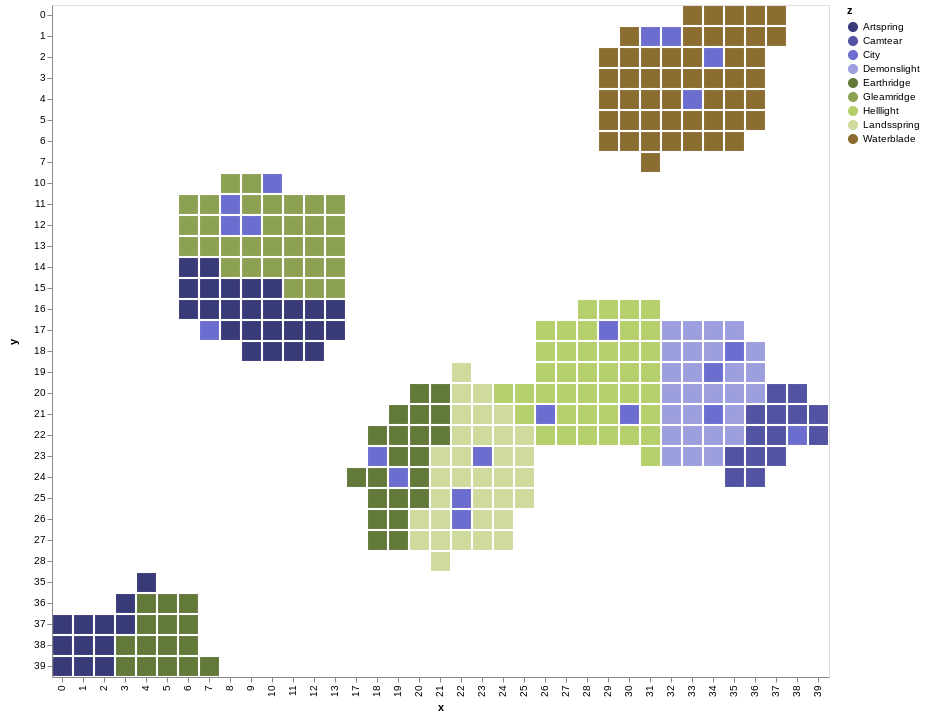

In [37]:
draw.drawboarders(world.df_features)

# The age of the Conflict

The terrain and all of the natural features are formed in the first age. Cities and nations in the second. In the third age chaos will shift the natural order and cause the tension that creates the objectives of the game. 


In [38]:
town = world.towns[1]
print(f"{town.name} is loyal to the nation of {town.nation}")
print(f"{town.diplomacy}")

Buckwish is loyal to the nation of Landsspring
{'nation': 'Landsspring', 'national fealty': 1}


People have loyalty to thier nations, as well as towns. Nations have a loyalty to each other. Towns have speakers, who represent the town. Nations have rulers. 

In [39]:
example_nation = world.nations[1]
print (example_nation.ruler," has a temperment of ",example_nation.ruler.temperment)
print (example_nation.get_capitol().speaker," has a loyalty of ",example_nation.get_capitol().speaker.loyalty)

Vofrorg the Ruler of the nation of Helllight  has a temperment of  0.23
Anardumber the Speaker of Servantsborourgh  has a loyalty of  0.5


In [40]:
world.get_filtered_chord(t=['plain','mountain','forrest'],n=example_nation.name,r='key')

'7:39'

In [41]:
example_nation.towns

[capitol of Servantsborourgh: population: 5 location: [29,17] founded 1,
 town of Falllair: population: 3 location: [30,21] founded 4,
 town of Tearspring: population: 4 location: [26,21] founded 6]

## Swaying favor with other nations

Events cause the relationship to sway between nations. This can be done by passing the `nation` or list of `nation` objects into the `alter_favor` function. 

In [42]:
nations.treaties

,stance,favor
0,sworn enemies,0.0
1,war,0.1
2,tense,0.3
3,peace,0.6
4,allies,0.9


Altering the favor of a nation is a complicated function. 

In [43]:
help(nations.alter_favor)

Help on function alter_favor in module lib.builders.nations:

alter_favor(s, o, a)
    s = the target nation(s) (obj or list). s will not change. O's favor of s will change.
    o = the nation(s) (obj or list) who's favor is change. O's favor of s will change
    
    Examples:
    (a,[o]) each nation in o's favor of a is changed by s
    (a,o) o's favor of a is changed by s
    ([a],o) o's favor of each nation in a is changed by s
    s = amount of change (int)
    
    national relationship with itself doesn't decay, but town and person loyalty can.



### example 1: one nation does something that many other nations's don't like. 

In [44]:
s_nation = world.nations[0]
o_nations = world.nations[1:3]
affect = -.25
nations.alter_favor(s_nation,o_nations,affect)

In [45]:
print("subject nations (nations who have done the deed)")
print(f"{s_nation} did something {affect} to {o_nations}")
print(s_nation,"\n",yaml.dump(s_nation.diplomacy))

print("object nations (nations who's favor is affected by the deed)")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in o_nations]


subject nations (nations who have done the deed)
Nation of Waterblade did something -0.25 to [Nation of Helllight, Nation of Gleamridge]
Nation of Waterblade 
 Artspring:
  favor: 0.8
  stance: peace
Camtear:
  favor: 0.8
  stance: peace
Demonslight:
  favor: 0.8
  stance: peace
Earthridge:
  favor: 0.8
  stance: peace
Gleamridge:
  favor: 0.8
  stance: peace
Helllight:
  favor: 0.8
  stance: peace
Landsspring:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Helllight 
 Artspring:
  favor: 0.8
  stance: peace
Camtear:
  favor: 0.8
  stance: peace
Demonslight:
  favor: 0.8
  stance: peace
Earthridge:
  favor: 0.8
  stance: peace
Gleamridge:
  favor: 0.8
  stance: peace
Landsspring:
  favor: 0.8
  stance: peace
Waterblade:
  favor: 0.55
  stance: tense

Nation of Gleamridge 
 Artspring:
  favor: 0.8
  stance: peace
Camtear:
  favor: 0.8
  stance: peace
Demonslight:
  favor: 0.8
  stance: peace
Earthridge:
  favor: 0.8
  stance: peace
H

[None, None]

### example 2: several nations does something that annother nation likes. 

In [46]:
s_nations = world.nations[2:4]
o_nation = world.nations[5]
affect = .25

nations.alter_favor(s_nations,o_nation,affect)

In [47]:
print("subject nations (nations who have done the deed)")
print(f"{s_nations} did something {affect} to {o_nation}")
[print(j,"\n",yaml.dump(j.diplomacy)) for j in s_nations]
print("object nations (nations who's favor is affected by the deed)")
print(o_nation,"\n",yaml.dump(o_nation.diplomacy))

subject nations (nations who have done the deed)
[Nation of Gleamridge, Nation of Demonslight] did something 0.25 to Nation of Landsspring
Nation of Gleamridge 
 Artspring:
  favor: 0.8
  stance: peace
Camtear:
  favor: 0.8
  stance: peace
Demonslight:
  favor: 0.8
  stance: peace
Earthridge:
  favor: 0.8
  stance: peace
Helllight:
  favor: 0.8
  stance: peace
Landsspring:
  favor: 0.8
  stance: peace
Waterblade:
  favor: 0.55
  stance: tense

Nation of Demonslight 
 Artspring:
  favor: 0.8
  stance: peace
Camtear:
  favor: 0.8
  stance: peace
Earthridge:
  favor: 0.8
  stance: peace
Gleamridge:
  favor: 0.8
  stance: peace
Helllight:
  favor: 0.8
  stance: peace
Landsspring:
  favor: 0.8
  stance: peace
Waterblade:
  favor: 0.8
  stance: peace

object nations (nations who's favor is affected by the deed)
Nation of Landsspring 
 Artspring:
  favor: 0.8
  stance: peace
Camtear:
  favor: 0.8
  stance: peace
Demonslight:
  favor: 1
  stance: allies
Earthridge:
  favor: 0.8
  stance: peace

Events are thier own thing. They aren't `culture` or `landscape`. They happen at the beginning of the game and depending on `culture.chaos` happen when the character moves from area to area. 

In [48]:
e = events.get_possible_events()
e

['bandits', 'marrage', 'raiders', 'temple']

 `culture.eons` determines how many years will pass with a possibility of an event happening. `culture.chaos` determines how likely an event is to occur.

In [54]:
world.culture.eons,world.culture.chaos

(10, 0.6)

In [55]:
#now to run through the eons and let fate happen
all_events = events.pass_through_time(world,nations)
all_events

['great_hall']
['great_hall', 'temple']


['0: a great temple was founded in the nation of [Nation of Landsspring]',
 '1: nothing happend during this period.',
 '2: bandits have set up camp in the None of [Nation of Gleamridge]',
 '3: raiders from [Nation of Landsspring], plundered [Nation of Earthridge, Nation of Gleamridge, Nation of Artspring]',
 '4: a noble from [Nation of Artspring] was married to a noble in [Nation of Waterblade]',
 '5: nothing happend during this period.',
 '6: a great temple was founded in the nation of [Nation of Earthridge]',
 '7: bandits have set up camp in the None of [Nation of Camtear]',
 '8: raiders from [Nation of Waterblade], plundered [Nation of Gleamridge, Nation of Helllight, Nation of Landsspring]',
 '9: bandits have set up camp in the None of [Nation of Helllight]']

# Monsters and Enemies

In [56]:
world.culture.chaos

0.6

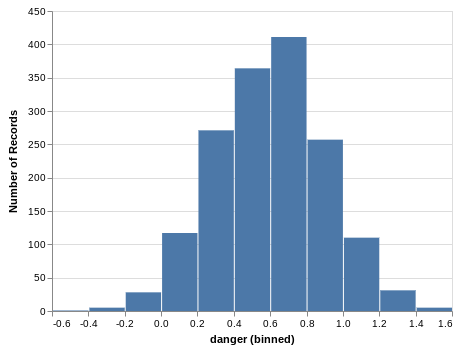

In [57]:
world = events.add_chaos_to_world(world)

alt.Chart(world.df_features).mark_bar().encode(
    alt.X("danger", bin=True),
    y='count()',
)

# Saving the local copy

Saving a local copy of the pickled file for update. TODO: add function to save pickle in S3

In [58]:
world.df_features.head(10)

,y,rainfall,x,key,elevation,terrain,feature,nation number,nation,z,danger
key,,,,,,,,,,,
0:0,0,3.0,0,0:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.255
1:0,0,2.0,1,1:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.792
2:0,0,1.0,2,2:0,1.0,ocean,NaN,NaN,NaN,NaN,0.543
3:0,0,0.0,3,3:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.486
4:0,0,0.0,4,4:0,-1.0,ocean,NaN,NaN,NaN,NaN,0.826
5:0,0,0.0,5,5:0,-2.0,ocean,NaN,NaN,NaN,NaN,0.464
6:0,0,0.0,6,6:0,1.0,ocean,NaN,NaN,NaN,NaN,0.657
7:0,0,1.0,7,7:0,0.0,ocean,NaN,NaN,NaN,NaN,0.804
8:0,0,2.0,8,8:0,0.0,ocean,NaN,NaN,NaN,NaN,0.727


In [59]:
with open('world.p', 'wb') as pickle_file:
    pickle.dump(world, pickle_file)